In [1]:
!pip install --upgrade pip
!pip install -U python-dotenv
!pip install PyMySQL

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (20.1.1)
Requirement already up-to-date: python-dotenv in /opt/conda/lib/python3.6/site-packages (0.14.0)


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import os
import time

import pymysql

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [30]:
# DB_CONN INFOS
DB_USER = os.getenv('MYSQL_USER')
DB_PASSWD = os.getenv('MYSQL_PASSWORD')
DB_HOST = os.getenv('MYSQL_HOST')
DB_DB = os.getenv('MYSQL_DATABASE')

# Connect to db
db = pymysql.connect(
    user=DB_USER, 
    passwd=DB_PASSWD, 
    host=DB_HOST, 
    db=DB_DB, 
    charset='utf8'
)

# Set cursor
cursor = db.cursor(pymysql.cursors.DictCursor)

In [35]:
# Get all stations ids in database
sql = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = %s;"
cursor.execute(sql, DB_DB)
stationIds = cursor.fetchall()
stationIds = [stationId['TABLE_NAME'] for stationId in stationIds]

In [37]:
start = time.time()

count = 0
for stationId in stationIds:
    sql = "SELECT parkingBikeTotCnt FROM `{}`".format(stationId)
    cursor.execute(sql)
    res = cursor.fetchall()

    data = pd.DataFrame(res)
    y = pd.DataFrame(data.parkingBikeTotCnt)

    y = y[:2160]

    scaler = MinMaxScaler()
    y = scaler.fit_transform(y)
    count += y.shape[0]
    
print("로딩시간 :", time.time() - start)
print("로드된 데이터 수 :", count)

로딩시간 : 52.12675070762634
로드된 데이터 수 : 4277446


In [38]:
p1 = int(len(y) * 0.85)
train, test = y[:p1], y[p1:]
print(len(train), len(test))

1836 324


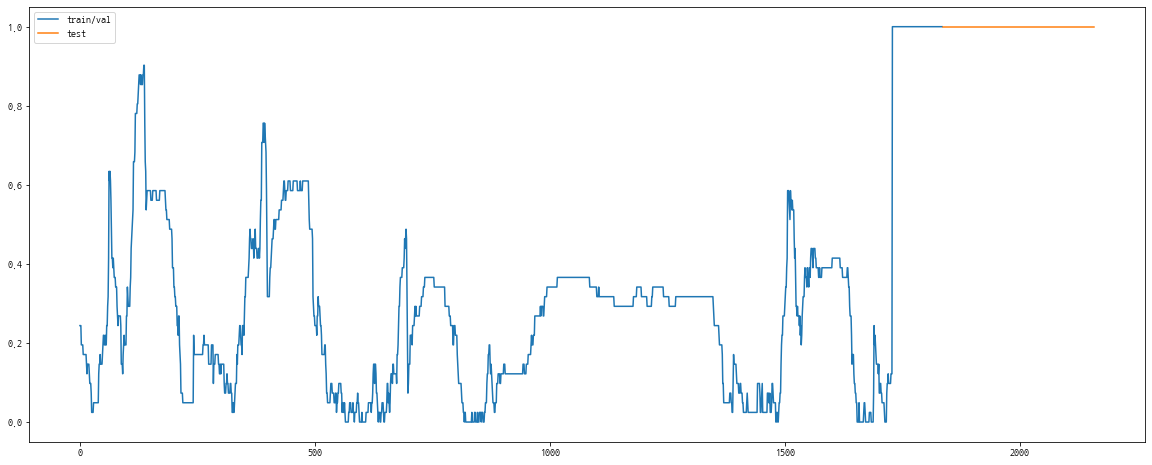

In [39]:
plt.figure(figsize=(20, 8))
plt.plot(range(0, p1), train, label="train/val")
plt.plot(range(p1, len(y)), test, label="test")

plt.legend()

In [40]:
def create_dataset(dataset, look_back=5, nPredicted = 5):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-nPredicted + 1):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back: i + look_back + nPredicted, 0])
	return np.array(dataX), np.array(dataY)

In [41]:
look_back = 18
nPredicted = 6

# Create Shifted Dataset
trainX, trainY = create_dataset(train, look_back, nPredicted)
testX, testY = create_dataset(test, look_back, nPredicted)

# Reshape
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainY = np.reshape(trainY, (trainY.shape[0], trainY.shape[1], 1))
testY = np.reshape(testY, (testY.shape[0], testY.shape[1], 1))

print(trainX.shape, trainY.shape)

(1813, 18, 1) (1813, 6, 1)


In [42]:
model = Sequential()

model.add(LSTM(20, activation='linear', input_shape=(look_back, 1)))
model.add(RepeatVector(nPredicted))
model.add(LSTM(20, activation='linear', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 6, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 20)             3280      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 1)              21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [43]:
start = time.time()

history = model.fit(trainX, trainY, epochs=65, batch_size=64)

print("학습시간 :", time.time() - start)
print("last loss :", history.history['loss'][-1:])

Instructions for updating:
Use tf.cast instead.
Epoch 1/65
1813/1813 [==============================] - 3s 2ms/step - loss: 0.0890
Epoch 2/65
1813/1813 [==============================] - 1s 387us/step - loss: 0.0289
Epoch 3/65
1813/1813 [==============================] - 1s 395us/step - loss: 0.0195
Epoch 4/65
1813/1813 [==============================] - 1s 388us/step - loss: 0.0134
Epoch 5/65
1813/1813 [==============================] - 1s 394us/step - loss: 0.0108
Epoch 6/65
1813/1813 [==============================] - 1s 390us/step - loss: 0.0093
Epoch 7/65
1813/1813 [==============================] - 1s 392us/step - loss: 0.0086
Epoch 8/65
1813/1813 [==============================] - 1s 390us/step - loss: 0.0081
Epoch 9/65
1813/1813 [==============================] - 1s 395us/step - loss: 0.0077
Epoch 10/65
1813/1813 [==============================] - 1s 390us/step - loss: 0.0074
Epoch 11/65
1813/1813 [==============================] - 1s 388us/step - loss: 0.0071
Epoch 12/65
1813/

((306, 1), (301, 6))

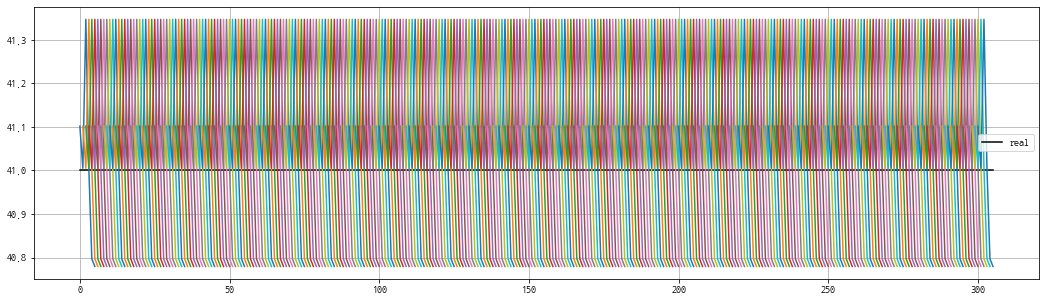

In [44]:
pred = model.predict(testX, batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
#pred = np.around(pred)

plt.figure(figsize=(18, 5))
plt.grid(True)  

real = scaler.inverse_transform(test[look_back:])
plt.plot(real, label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i])

real.shape, pred.shape

((1818, 1), (1813, 6))

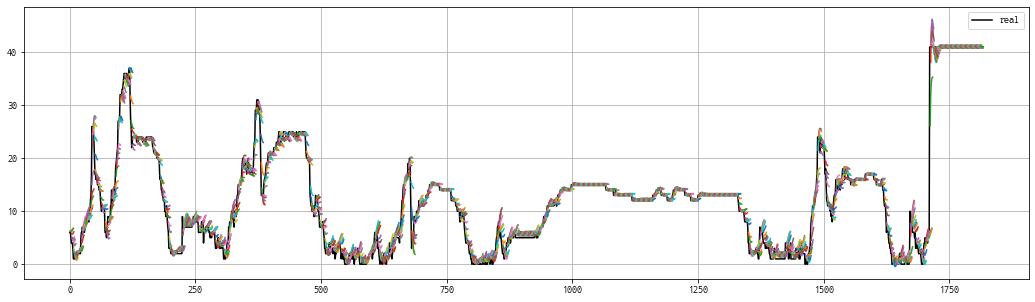

In [45]:
pred = model.predict(trainX, batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
#pred = pred.astype(int)

plt.figure(figsize=(18, 5))
plt.grid(True)

real = scaler.inverse_transform(train[look_back:])
plt.plot(real, label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i], "-")

real.shape, pred.shape